# Pratice 1.2 Quantum Neural Networks

MQIST 2025/26: Quantum Computing and Machine Learning

Alfredo Chavert Sancho

Pedro Herrero Maldonado

***
Cosas a probar:
- Cambiar número de qubits (más componentes en PCA)
- Cambiar número de capas del ansatz
- Cambiar feature map (ZZFeatureMap, PauliFeatureMap, etc)
- Cambiar optimizador: COBYLA, SPSA
***

## Data loading and preprocessing

The `load_breast_cancer` function from `sklearn.datasets` is used to load the breast cancer dataset. This dataset contains features computed from breast cancer biopsy images, along with labels indicating whether the cancer is malignant or benign. So this is a binary classification problem.

In [1]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data # features
y = data.target # labels

print("Original shape:", X.shape)

Original shape: (569, 30)


For the prepocessing the data to be used in the quantum neural network, we will use  ``StandardScaler`` from ``sklearn.preprocessing`` to normalize it  since all the data is numeric.

We will also use ``PCA`` from ``sklearn.decomposition`` to reduce the dimensionality of the data to reduce the number of qubits needed in the quantum neural network.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Standardize (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (ex: reduce to 2 components for visualization or QML input)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Shape after PCA:", X_pca.shape) # (150, 2)
print("Explained variance:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Shape after PCA: (569, 2)
Explained variance: [0.44272026 0.18971182]
Total variance explained: 0.6324320765155946


- PC1 (0.44): The first dimension alone holds 44.3% of the information in your dataset. This is the single strongest pattern in the data (likely related to the overall size/magnitude of the tumor cells).

- PC2 (0.19): The second dimension adds another 19.0% of distinct information (likely related to the shape/irregularity of the cells).

Total (0.63): When you combine them, you are preserving 63.2% of the original data's structure. For visualization purposes, this is often sufficient to see meaningful patterns.

Visualize the data to be used in the quantum neural network. 

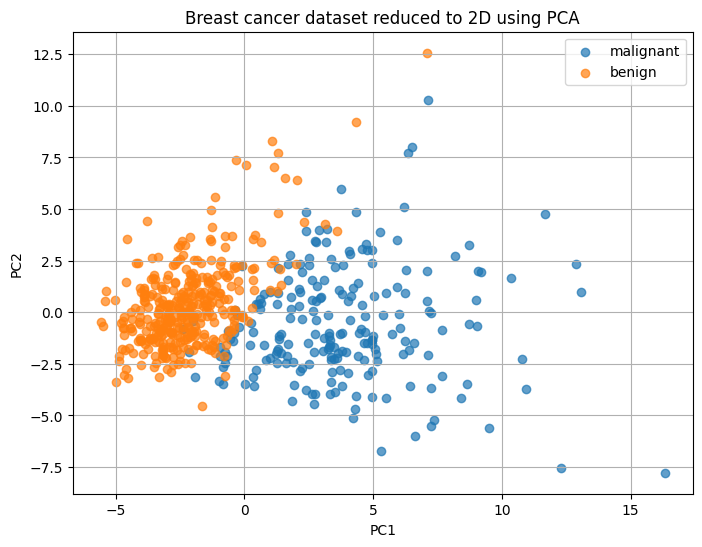

In [3]:
# Plot the result
plt.figure(figsize=(8,6))
for label in [0, 1]:
    plt.scatter(
                X_pca[y == label, 0],
                X_pca[y == label, 1],
                label=data.target_names[label],
                alpha=0.7
                )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Breast cancer dataset reduced to 2D using PCA")
plt.legend()
plt.grid(True)
plt.show()

As we see in the plot, the two classes (malignant and benign) are somewhat separable in this 2D PCA space, which is promising for classification tasks using a quantum neural network.

To ensure better total variance retention, we will consider enough principal components to capture at least 95% of the variance in the dataset.

In [4]:
# Apply PCA (to 2 components for QML input)
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

print("Shape after PCA:", X_pca.shape) # (150, 2)
print("Explained variance:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Shape after PCA: (569, 4)
Explained variance: [0.44272026 0.18971182 0.09393163 0.06602135]
Total variance explained: 0.7923850582446098


Next we will divide the data into train and test

In [5]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

# Set the seed so results are reproducible
algorithm_globals.random_seed = 42

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
            X_pca, y, test_size=0.2, random_state=algorithm_globals.random_seed,
)

## Quantum neural network to predict class of each case

### Feature map

Lets choose a **Feature map** to represent the data in a quantum state

In [6]:
# Number of features after PCA
num_features = X_pca.shape[1]
print(f'The number of features after PCA is: {num_features}')

from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap

'Choose a feature map to represent the data in a quantum state'
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 3,
                              entanglement = 'linear')

Z_feature_map = ZFeatureMap(feature_dimension = num_features,
                            reps = 3)

Pauli_feature_map = PauliFeatureMap(feature_dimension = num_features,
                                    reps = 3,
                                    paulis = ['ZZ', 'XX', 'YY'],
                                    entanglement = 'linear')

feature_map = Z_feature_map

The number of features after PCA is: 4


### Ansatz

Next, we will choose a **Variational form (ansatz)** for our quantum neural network

In [7]:
from qiskit.circuit.library import RealAmplitudes, TwoLocal, NLocal, EfficientSU2

'Choose a variational form (ansatz) for our quantum neural network'
real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, 
                                        reps = 3, 
                                        name = 'RealAmplitudes')

two_local_ansatz = TwoLocal(num_qubits = num_features, 
                            rotation_blocks = 'ry', 
                            entanglement_blocks = 'cz', 
                            reps = 3, 
                            name = 'TwoLocal')

esu2_ansatz = EfficientSU2(num_qubits = num_features, 
                           entanglement = 'full', 
                           reps = 3, 
                           name = 'EfficientSU2')


ansatz = real_amplitudes_ansatz

### Optimizer

An **optimizer** is needed to minimize the loss function during the training of the quantum neural network. 

In [12]:
from qiskit_machine_learning.optimizers import COBYLA, SPSA, ADAM, GradientDescent

spsa_optimizer = SPSA(maxiter = 100)

adam_optimizer = ADAM(maxiter = 10000, 
                tol = 1e-06, 
                lr = 0.001, 
                beta_1 = 0.9, 
                beta_2 = 0.99, 
                noise_factor = 1e-08, 
                eps = 1e-10)

cobyla_optimizer = COBYLA(maxiter = 200, 
                    disp = False, 
                    rhobeg = 1.0)

gd_optimizer = GradientDescent(maxiter = 100, 
                         learning_rate = 0.01, 
                         tol = 1e-07)

optimizer = cobyla_optimizer

### Variational Quantum Classifier

Finally let's build a Variational Quantum Classifier (VQC) using this feature map, ansatz and optimizer.

But first, we will define a callback function to visualize the training progress.

0.9337108887914598


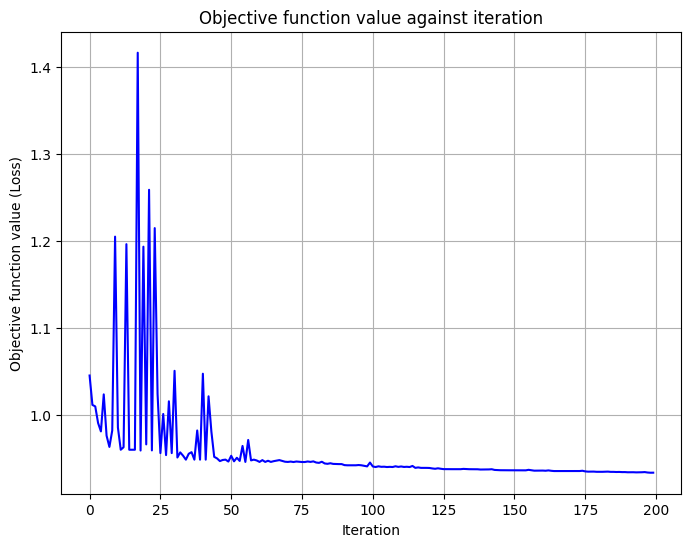

Training time: 237 seconds


In [14]:
import matplotlib.pyplot as plt
from qiskit_machine_learning.algorithms.classifiers import VQC
from IPython.display import clear_output 
import time

# Initialize the storage for the plot
objective_func_vals = []

# Define the callback
def callback_graph(_weights, _obj_func_eval):
    '''Callback function to visualize training progress
    
    Parameters:
        weights : Current parameters of the ansatz.
        obj_func_eval : Current loss value (error rate).
    '''
    
    clear_output(wait=True) # Clear previous output to update the plot
    print(_obj_func_eval)
    objective_func_vals.append(_obj_func_eval)
    
    plt.figure(figsize=(8,6))
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value (Loss)")
    plt.plot(range(len(_objective_func_vals)), _objective_func_vals, color='blue')
    plt.grid(True)
    plt.show()

# Setup and Run VQC
vqc = VQC(
    feature_map = feature_map,
    ansatz = ansatz,
    optimizer = optimizer,
    callback = callback_graph)
start = time.time()

# NOTE: VQC works best if labels are One-Hot Encoded (e.g., [[0,1], [1,0]])
# If you get a shape error, you may need to apply OHE to y_train.
vqc.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

### Results for the VQC

In [17]:
train_score_q4 = vqc.score(X_train, y_train)
test_score_q4 = vqc.score(X_test, y_test)

print(f"Quantum VQC accuracy on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC accuracy on the test dataset:     {test_score_q4:.2f}")

Quantum VQC accuracy on the training dataset: 0.65
Quantum VQC accuracy on the test dataset:     0.64


We can see that the accuracy is low (regarding our limited data representation due to the PCA), but the model doesn't present overfitting.

## Testing feature maps

First, we are going to test some typical feature maps for the VQC, with the same ansatz and optimizer, to better asses its performance.

### ZZ Feature Map

0.9437205615307988


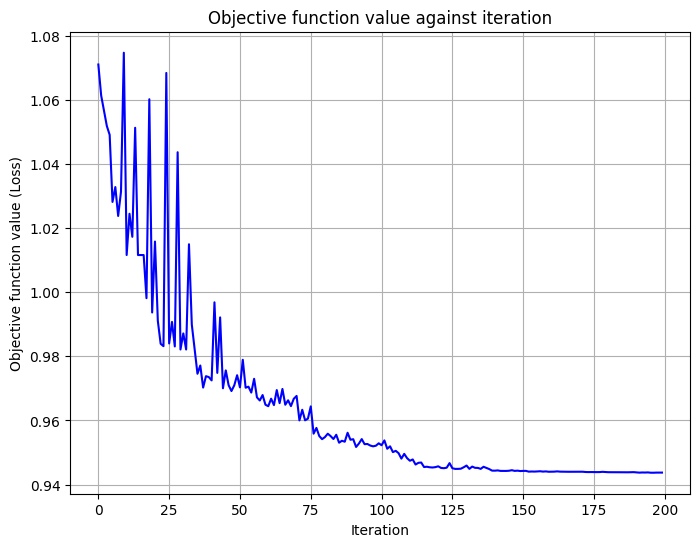

Training time: 327 seconds


In [20]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 3,
                              entanglement = 'linear')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, reps = 3, name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 200, 
                    disp = False, 
                    rhobeg = 1.0)

vqc_ZZ_RA_COBYLA = VQC(feature_map = ZZ_feature_map,
                       ansatz = real_amplitudes_ansatz,
                       optimizer = cobyla_optimizer,
                       callback = callback_graph)
start = time.time()

# NOTE: VQC works best if labels are One-Hot Encoded (e.g., [[0,1], [1,0]])
# If you get a shape error, you may need to apply OHE to y_train.
objective_func_vals = []
vqc_ZZ_RA_COBYLA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [21]:
train_score_ZZ_RA_COBYLA = vqc_ZZ_RA_COBYLA.score(X_train, y_train)
test_score_ZZ_RA_COBYLA = vqc_ZZ_RA_COBYLA.score(X_test, y_test)

print(f"ZZ Feature map accuracy on the training dataset: {train_score_ZZ_RA_COBYLA:.2f}")
print(f"ZZ Feature map accuracy on the test dataset:     {test_score_ZZ_RA_COBYLA:.2f}")

ZZ Feature map accuracy on the training dataset: 0.63
ZZ Feature map accuracy on the test dataset:     0.55


### Pauli Feature Map

0.9388561340594427


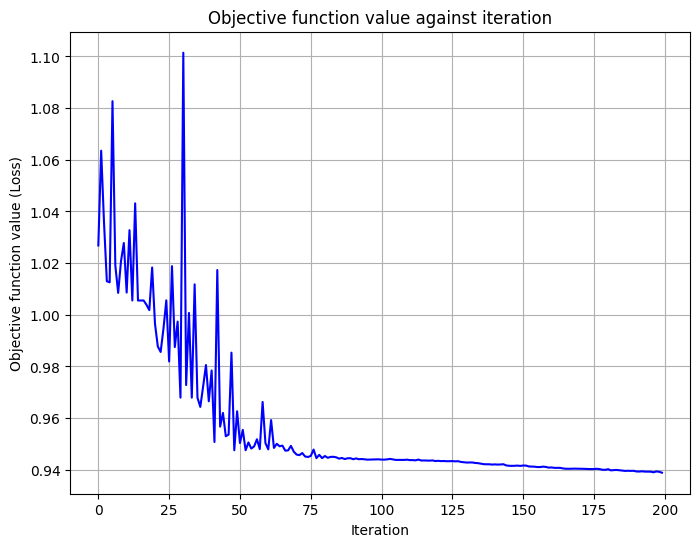

Training time: 620 seconds


In [22]:
Pauli_feature_map = PauliFeatureMap(feature_dimension = num_features,
                                    reps = 3,
                                    paulis = ['ZZ', 'XX', 'YY'],
                                    entanglement = 'linear')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, reps = 3, name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 200, 
                    disp = False, 
                    rhobeg = 1.0)

vqc_Pauli_RA_COBYLA = VQC(feature_map = Pauli_feature_map,
                       ansatz = real_amplitudes_ansatz,
                       optimizer = cobyla_optimizer,
                       callback = callback_graph)
start = time.time()

# NOTE: VQC works best if labels are One-Hot Encoded (e.g., [[0,1], [1,0]])
# If you get a shape error, you may need to apply OHE to y_train.
objective_func_vals = []
vqc_Pauli_RA_COBYLA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [23]:
train_score_Pauli_RA_COBYLA = vqc_Pauli_RA_COBYLA.score(X_train, y_train)
test_score_Pauli_RA_COBYLA = vqc_Pauli_RA_COBYLA.score(X_test, y_test)

print(f"Pauli Feature map accuracy on the training dataset: {train_score_Pauli_RA_COBYLA:.2f}")
print(f"Pauli Feature map accuracy on the test dataset:     {test_score_Pauli_RA_COBYLA:.2f}")

ZZ Feature map accuracy on the training dataset: 0.63
ZZ Feature map accuracy on the test dataset:     0.60


## Testing Ansatzs

### Two Local Ansatz

0.9380198092485313


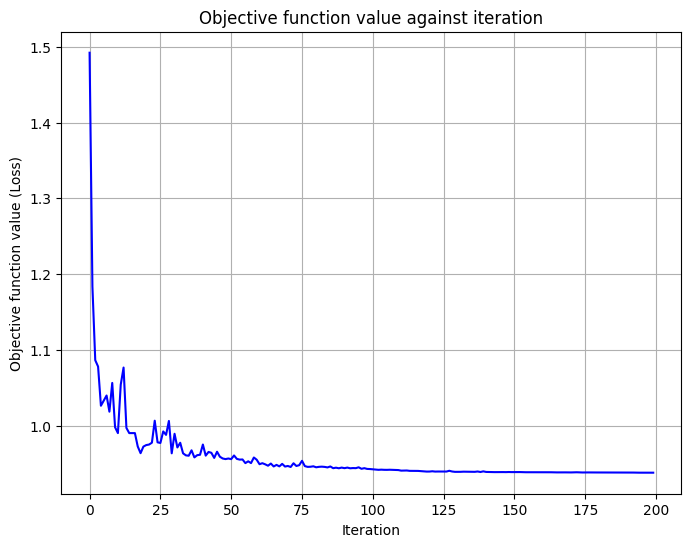

Training time: 240 seconds


In [25]:
Z_feature_map = ZFeatureMap(feature_dimension = num_features,
                            reps = 3)

two_local_ansatz = TwoLocal(num_qubits = num_features, 
                            rotation_blocks = 'ry', 
                            entanglement_blocks = 'cz', 
                            reps = 3, 
                            name = 'TwoLocal')

cobyla_optimizer = COBYLA(maxiter = 200, 
                    disp = False, 
                    rhobeg = 1.0)

vqc_Z_2L_COBYLA = VQC(feature_map = Z_feature_map,
                       ansatz = two_local_ansatz,
                       optimizer = cobyla_optimizer,
                       callback = callback_graph)
start = time.time()


objective_func_vals = []
vqc_Z_2L_COBYLA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [26]:
train_score_Z_2L_COBYLA = vqc_Z_2L_COBYLA.score(X_train, y_train)
test_score_Z_2L_COBYLA = vqc_Z_2L_COBYLA.score(X_test, y_test)

print(f"Two local ansatz accuracy on the training dataset: {train_score_Z_2L_COBYLA:.2f}")
print(f"Two local ansatz accuracy on the test dataset:     {test_score_Z_2L_COBYLA:.2f}")

Two local ansatz accuracy on the training dataset: 0.64
Two local ansatz accuracy on the test dataset:     0.60


### ESU2 Ansatz

0.9419889665915959


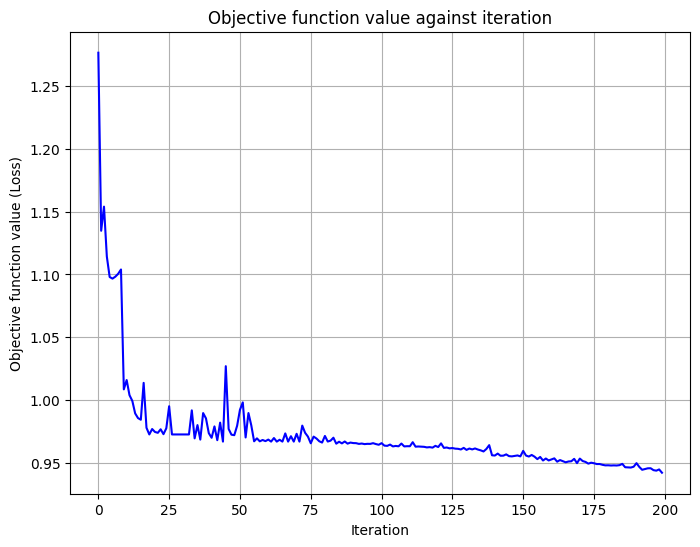

Training time: 335 seconds


In [27]:
Z_feature_map = ZFeatureMap(feature_dimension = num_features,
                            reps = 3)

esu2_ansatz = EfficientSU2(num_qubits = num_features, 
                           entanglement = 'full', 
                           reps = 3, 
                           name = 'EfficientSU2')

cobyla_optimizer = COBYLA(maxiter = 200, 
                    disp = False, 
                    rhobeg = 1.0)

vqc_Z_ESU2_COBYLA = VQC(feature_map = Z_feature_map,
                       ansatz = esu2_ansatz,
                       optimizer = cobyla_optimizer,
                       callback = callback_graph)
start = time.time()


objective_func_vals = []
vqc_Z_ESU2_COBYLA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [28]:
train_score_Z_ESU2_COBYLA = vqc_Z_ESU2_COBYLA.score(X_train, y_train)
test_score_Z_ESU2_COBYLA = vqc_Z_ESU2_COBYLA.score(X_test, y_test)

print(f"ESU2 ansatz accuracy on the training dataset: {train_score_Z_ESU2_COBYLA:.2f}")
print(f"ESU2 ansatz accuracy on the test dataset:     {test_score_Z_ESU2_COBYLA:.2f}")

ESU2 ansatz accuracy on the training dataset: 0.63
ESU2 ansatz accuracy on the test dataset:     0.59


## Testing Optimizers

### Adam Optimizer

In [30]:
Z_feature_map = ZFeatureMap(feature_dimension = num_features,
                            reps = 3)

esu2_ansatz = EfficientSU2(num_qubits = num_features, 
                           entanglement = 'full', 
                           reps = 3, 
                           name = 'EfficientSU2')

adam_optimizer = ADAM(maxiter = 200, 
                tol = 1e-06, 
                lr = 0.001, 
                beta_1 = 0.9, 
                beta_2 = 0.99, 
                noise_factor = 1e-08, 
                eps = 1e-10)

vqc_Z_ESU2_ADAM = VQC(feature_map = Z_feature_map,
                       ansatz = esu2_ansatz,
                       optimizer = adam_optimizer,
                       callback = callback_graph)
start = time.time()


objective_func_vals = []
vqc_Z_ESU2_ADAM.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

KeyboardInterrupt: 

In [ ]:
train_score_Z_ESU2_ADAM = vqc_Z_ESU2_ADAM.score(X_train, y_train)
test_score_Z_ESU2_ADAM = vqc_Z_ESU2_ADAM.score(X_test, y_test)

print(f"Adam optimizer accuracy on the training dataset: {train_score_Z_ESU2_ADAM:.2f}")
print(f"Adam optimizer accuracy on the test dataset:     {test_score_Z_ESU2_ADAM:.2f}")

### Gradient Descent Optimizer

In [ ]:
Z_feature_map = ZFeatureMap(feature_dimension = num_features,
                            reps = 3)

esu2_ansatz = EfficientSU2(num_qubits = num_features, 
                           entanglement = 'full', 
                           reps = 3, 
                           name = 'EfficientSU2')

gd_optimizer = GradientDescent(maxiter = 100, 
                         learning_rate = 0.01, 
                         tol = 1e-07)

vqc_Z_ESU2_GD = VQC(feature_map = Z_feature_map,
                       ansatz = esu2_ansatz,
                       optimizer = gd_optimizer,
                       callback = callback_graph)
start = time.time()


objective_func_vals = []
vqc_Z_ESU2_GD.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_Z_ESU2_GD = vqc_Z_ESU2_GD.score(X_train, y_train)
test_score_Z_ESU2_GD = vqc_Z_ESU2_GD.score(X_test, y_test)

print(f"Gradiant descendt optimizer accuracy on the training dataset: {train_score_Z_ESU2_GD:.2f}")
print(f"Gradiant descendt optimizer accuracy on the test dataset:     {test_score_Z_ESU2_GD:.2f}")

### SPSA Optimizer

In [ ]:
Z_feature_map = ZFeatureMap(feature_dimension = num_features,
                            reps = 3)

esu2_ansatz = EfficientSU2(num_qubits = num_features, 
                           entanglement = 'full', 
                           reps = 3, 
                           name = 'EfficientSU2')

spsa_optimizer = SPSA(maxiter = 100)

vqc_Z_ESU2_SPSA = VQC(feature_map = Z_feature_map,
                       ansatz = esu2_ansatz,
                       optimizer = spsa_optimizer,
                       callback = callback_graph)
start = time.time()


objective_func_vals = []
vqc_Z_ESU2_SPSA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_Z_ESU2_SPSA = vqc_Z_ESU2_SPSA.score(X_train, y_train)
test_score_Z_ESU2_SPSA = vqc_Z_ESU2_SPSA.score(X_test, y_test)

print(f"SPSA optimizer accuracy on the training dataset: {train_score_Z_ESU2_SPSA:.2f}")
print(f"SPSA optimizer accuracy on the test dataset:     {test_score_Z_ESU2_SPSA:.2f}")

## More PCA components for the best performing model

In [ ]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

print("Shape after PCA:", X_pca.shape) # (150, 2)
print("Explained variance:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

In [ ]:
algorithm_globals.random_seed = 42

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = algorithm_globals.random_seed)